<a href="https://colab.research.google.com/github/ozgesengil/fMRI_Analysis_Scripts/blob/main/Granger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Granger Causality
Starting with usual definitions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2, gamma

def hrf_double_gamma(t,n1,n2,lmbd1,lmbd2,t01,t02,a):
  c = (gamma.cdf(t[t.size-1],n1,loc=t01,scale=lmbd1)
        - a * gamma.cdf(t[t.size-1],n2,loc=t02,scale=lmbd2))
  return ( 1/c * (gamma.pdf(t,n1,scale=lmbd1,loc=t01)
                   - a * gamma.pdf(t,n2,scale=lmbd2,loc=t02)))

def hrf_single_gamma(t,n,lmbd,t0):
  return gamma.pdf(t,n,loc=t0,scale=lmbd)

def bold_response(n, h):
  return np.convolve(n,h)

##Neuronal responses
Here is the neuronal response

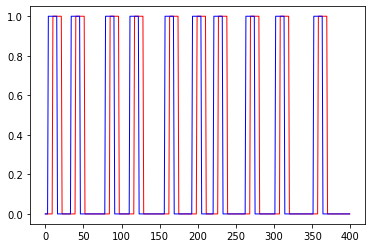

In [ ]:
nTR = 200
TR = 2 # TR in seconds
eventDuration = 6 * TR
initialRest = 5 * TR
finalRest = 30 * TR
ISImin = 5 * TR
ISImax = 20 *TR

box1 = np.zeros(nTR*TR)
box2 = np.zeros(nTR*TR)
box1[initialRest:initialRest+eventDuration] = np.ones(eventDuration)
t = initialRest + eventDuration
while t<nTR*TR-finalRest:
    ISI = int(np.rint(np.random.uniform(low = ISImin, high = ISImax)))
    box1[t+ISI:t+ISI+eventDuration] = np.ones(eventDuration)
    t = t + ISI+eventDuration

related_n = True #@param {type:'boolean'}
nShift = 6 #@param {type:"integer"}

if related_n:
    box2[0:nTR*TR-nShift] = box1[nShift:nTR*TR]
else:
    box2[initialRest:initialRest+eventDuration] = np.ones(eventDuration)
    t = initialRest + eventDuration
    while t<nTR*TR-finalRest:
        ISI = int(np.rint(np.random.uniform(low = ISImin, high = ISImax)))
        box2[t+ISI:t+ISI+eventDuration] = np.ones(eventDuration)
        t = t + ISI+eventDuration

plt.plot(box1, color='red', linestyle='solid', linewidth=1)
plt.plot(box2, color='blue', linestyle='solid', linewidth=1)
plt.show()

Next, convolve the neuronal responses with HIRFs

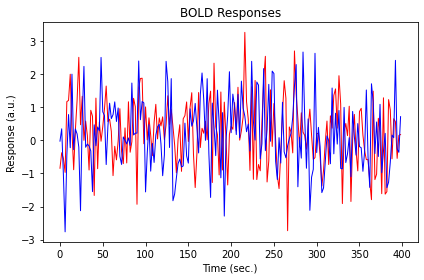

In [ ]:
# two slightly different HRFs
n1 = 4
lmbd1 = 2.0
t01 = 0
n2 = 7
lmbd2 = 2
t02 = 0
a = 0.3
time = np.arange(0,nTR*TR)

bold_double_gamma = hrf_double_gamma(time, n1, n2, lmbd1, lmbd2, t01, t02, a)
bold_single_gamma = hrf_single_gamma(time, n1, lmbd1, t01)

HRF1 = 'Single-Gamma' #@param ['Single-Gamma','Double-Gamma']
if HRF1 == "Single-Gamma":
  hrf1 = bold_single_gamma
elif HRF1 =="Double-Gamma":
  hrf1 = bold_double_gamma

HRF2 = 'Single-Gamma' #@param ['Single-Gamma','Double-Gamma']
if HRF2 =="Single-Gamma":
  hrf2 = bold_single_gamma
elif HRF2 =="Double-Gamma":
  hrf2 = bold_double_gamma

# corresponding BOLD responses
bold1 = bold_response(box1, hrf1)[0:nTR*TR:TR]
bold2 = bold_response(box2, hrf2)[0:nTR*TR:TR]

noise_sigma =  1#@param {type:"raw"};
bold1 += norm.rvs(scale=noise_sigma, size=bold1.size)
bold2 += norm.rvs(scale=noise_sigma, size=bold2.size)

#bold1 = (bold1 - np.mean(bold1))/np.std(bold1)
#bold2 = (bold2 - np.mean(bold2))/np.std(bold2)
plt.plot(time[0:nTR*TR:TR], bold1[0:nTR], color='red',
         linestyle='solid', linewidth=1)
plt.plot(time[0:nTR*TR:TR], bold2[0:nTR], color='blue', linestyle='solid', linewidth=1)
plt.title('BOLD Responses')
plt.xlabel('Time (sec.)')
plt.ylabel('Response (a.u.)')
plt.tight_layout()

##Autoregression Models
Here we model the second BOLD response (red curve above) using an autoregressive model. First p=1

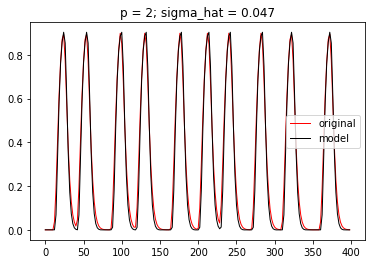

In [ ]:
p = 2 #@param{type:"slider", min:1, max:3, step:1}

if p == 1:
    x = bold1[0:nTR-p].reshape(nTR-p,1)
    xT = x.T
elif  p == 2:
    xT = np.vstack([bold1[p-1:nTR-p+1],bold1[p-2:nTR-p]])
    x = xT.T
else:
    xT = np.vstack([bold1[p-1:nTR-p+2],bold1[p-2:nTR-p+1], bold1[p-3:nTR-p]])
    x = xT.T

y = bold1[p:nTR].reshape(nTR-p,1)
beta_hat = (np.linalg.inv(xT.dot(x)).dot(xT)).dot(y)
PR = np.zeros(nTR)
PR[p:nTR] = x.dot(beta_hat).T

plt.plot(time[0:nTR*TR:TR], bold1[0:nTR], color='red',
         linestyle='solid', linewidth=1, label='original')
plt.plot(time[0:nTR*TR:TR], PR[0:nTR], color='black',
         linestyle='solid', linewidth=1, label='model')
errorT = y.T-PR[p:nTR]
error = errorT.T
var_hat_simple = (errorT).dot(error)/(nTR-p)
sigma_hat = np.sqrt(var_hat_simple)
plt.title('p = ' + str(p) +
          '; sigma_hat = {0:5.3f}'.format(sigma_hat[0][0]))
plt.legend()
plt.show()

##Full Regressive Model
The causal effect of first (blue) on second (red) response. p=2:

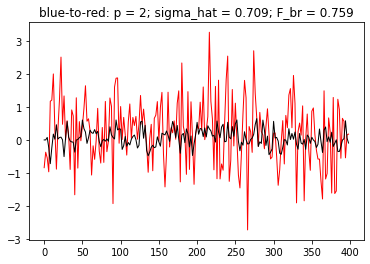

p-value= 1.140e-33 


In [ ]:
p = 2
#Simple model:
xT = np.vstack([bold1[p-1:nTR-p+1],bold1[p-2:nTR-p]])
x = xT.T
y = bold1[p:nTR].reshape(nTR-p,1)
beta_hat = (np.linalg.inv(xT.dot(x)).dot(xT)).dot(y)
PR = np.zeros(nTR)
PR[p:nTR] = x.dot(beta_hat).T
errorT = y.T-PR[p:nTR]
error = errorT.T
var_hat_simple = (errorT).dot(error)/(nTR-p)
#Full model:
xT = np.vstack([bold1[p-1:nTR-p+1], bold2[p-1:nTR-p+1],
                      bold1[p-2:nTR-p], bold2[p-2:nTR-p]] )
x = xT.T
y = bold1[p:nTR].reshape(nTR-p,1)
beta_hat = (np.linalg.inv(xT.dot(x)).dot(xT)).dot(y)
PR = np.zeros(nTR)
PR[p:nTR] = x.dot(beta_hat).T

plt.plot(time[0:nTR*TR:TR], bold1[0:nTR], color='red',
         linestyle='solid', linewidth=1, label='original')
plt.plot(time[0:nTR*TR:TR], PR[0:nTR], color='black',
         linestyle='solid', linewidth=1, label='model')
errorT = y.T-PR[p:nTR]
error = errorT.T
var_hat_full = (error.T).dot(error)/(2*(nTR-p))
sigma_hat = np.sqrt(var_hat_full)
F_ij = np.log(var_hat_simple/var_hat_full)

plt.title('p = ' + str(p) +
          '; sigma_hat = {0:5.3f}'.format(sigma_hat[0][0]))
plt.title('blue-to-red: p = ' + str(p) +
          '; sigma_hat = {0:5.3f}'.format(sigma_hat[0][0])
          + '; F_br = {0:5.3f}'.format(F_ij[0][0]))
plt.show()
#chi-square:
print('p-value= {0:5.3e} '.format(chi2.sf(nTR*F_ij[0][0],p)))


Next the causal effect of red on blue

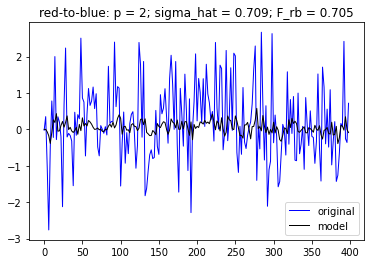

p-value= 2.330e-31 


In [ ]:
p = 2
#Simple model for blue
xT = np.vstack([bold2[p-1:nTR-p+1],bold2[p-2:nTR-p]])
x = xT.T
y = bold2[p:nTR].reshape(nTR-p,1)
beta_hat = (np.linalg.inv(xT.dot(x)).dot(xT)).dot(y)
PR = np.zeros(nTR)
PR[p:nTR] = x.dot(beta_hat).T
errorT = y.T-PR[p:nTR]
error = errorT.T
var_hat_simple = (error.T).dot(error)/(nTR-p)
# Full model
xT = np.vstack([bold2[p-1:nTR-p+1], bold1[p-1:nTR-p+1],
                      bold2[p-2:nTR-p], bold1[p-2:nTR-p]] )
x = xT.T
y = bold2[p:nTR].reshape(nTR-p,1)
beta_hat = (np.linalg.inv(xT.dot(x)).dot(xT)).dot(y)
PR = np.zeros(nTR)
PR[p:nTR] = x.dot(beta_hat).T

plt.plot(time[0:nTR*TR:TR], bold2[0:nTR], color='blue',
         linestyle='solid', linewidth=1, label='original')
plt.plot(time[0:nTR*TR:TR], PR[0:nTR], color='black',
         linestyle='solid', linewidth=1, label='model')
plt.legend()
errorT = y.T-PR[p:nTR]
error = errorT.T
var_hat_full = (error.T).dot(error)/(2*(nTR-p))
F_ji = np.log(var_hat_simple/var_hat_full)

plt.title('red-to-blue: p = ' + str(p) +
          '; sigma_hat = {0:5.3f}'.format(sigma_hat[0][0]) +
          '; F_rb = {0:5.3f}'.format(F_ji[0][0]))
plt.show()

print('p-value= {0:5.3e} '.format(chi2.sf(nTR*F_ji[0][0],p)))